This notebook implements the SVM Partial models for the News Prediction paper of Experiment Design. We will train separate models for each news agency Telegram channel, as described in the paper. Weirdly enough, the also added
the Guardian, BCC Persian and the Washington Post in their dataset, but they
are not mentioned in the paper ...

We will collect a few measures also used in the paper and investiagte the results.

As the first step, we will clone the dataset containing the Telegram data used by [Naseri 2019].

**ISSUES FOUND**

* **Which of the .bson files are actually used for the experiment?** There
is no indication if Washington Post and BBC Persia etc. are used for the
experiments, as they are not mentioned in the paper itself.

* **How are the binary labels acutally generated from the data?** There is no indication for the threshold they used in the paper. They mention only: "Therefore, we first found the thresholds that satisfy these percent-
ages for training and test sets and assigned a binary label to each
post (“popular” or “not popular”). "

* **How are the features generated from the data (manually, algorithm, ...)?** This would be important as the bson data does **not** have the same features. List of issues: What is the n-grams thing? How do we generate the hashtags and mention features? How are we supposed to generate the media-type features? What does Has Link mean (could be either the enitity type URL or a media page containing a url tag...).

* **THERE IS A TYPO MISTAKE IN THE FEATURES TABLE!!** We can't really reproduce
the #mentions features without guessing that they mean the count of the mentions
in a post (They use the same text as for the hashtags)

* **How are the NaN in the data handled?** Could be removed, zero-filled, interpolated. We just don't know...

# Feature Extraction

In [2]:
# Run only if needed, e.g. when the Telegram News Folder is not yet downloaded!
! git clone https://github.com/IceCream71/TelegramNews.git

fatal: destination path 'TelegramNews' already exists and is not an empty directory.


In [1]:
import pandas as pd
import seaborn as sns
import bson

def create_df_for_bson(path): 
  with open (path, 'rb') as f:
    data = bson.decode_all(f.read())

  df = pd.DataFrame(data)
  df = handle_NAS(df)
  df = extract_features(df)
  df = cut_date_range(df)
  df = drop_unused_features(df)
  return df

def handle_NAS(df):
  df = df.dropna(subset=['views'],axis=0)
  return df

def extract_features(df):
  df = create_datetime_features(df)
  df = add_channel_features(df)
  df = create_entity_features(df)
  return df

def create_datetime_features(df):
  df['age'] =  df.date
  df['date'] = pd.to_datetime(df.date, unit='s')
  df['year'] = df.date.dt.year
  df['month'] = df.date.dt.month
  df['day'] = df.date.dt.day
  df['weekday'] = df.date.dt.dayofweek
  df['hour'] = df.date.dt.hour
  return df

def cut_date_range(df):
  # March 8, 2017 to October 8, 2017.
  start_date = "2017-03-08"
  end_date  = "2017-10-08"
  mask = (df.date > start_date) & (df.date <= end_date)
  return df.loc[mask]

def add_channel_features(df):
  df['minViews'] = df.views.min()
  df['maxViews'] = df.views.max()
  df['meanViews'] = df.views.mean()
  df['stdViews'] = df.views.std()
  df['hourlyAvgPosts'] = df.groupby('hour').size().mean()
  df['dailyAvgPosts'] = df.groupby(['year','month','day']).size().mean()
  return df

def create_entity_features(df):
  # Convert the entity field from bson into the actual features.
  # For each row, check if media exists, if yes set media type.
  df['hasMedia'] = df.media.notnull()
  df['mediaType'] = df.apply(lambda x: x.media['_'] if x.hasMedia else '', axis=1)
  # Check if URL exists in entities, if exists, is a link
  df['hasLink'] = df.apply(lambda x: True if type(x.entities) != float and [d for d in x.entities if d['_'] ==  'messageEntityTextUrl'] else False, axis=1)
  # Collect the mentions from the entities feature
  df['mentions'] = df.apply(lambda x: len([d for d in x.entities if d['_'] == 'messageEntityMention']) if type(x.entities) != float else 0, axis=1)
  # Same as before for the hashtags
  df['hashtags'] = df.apply(lambda x: len([d for d in x.entities if d['_'] == 'messageEntityHashtag']) if type(x.entities) != float else 0, axis=1)
  return df

def drop_unused_features(df):
  return df.drop(labels=['_id','_','flags','post','id','to_id','reply_to_msg_id',
                  'media','channel','entities','message','fwd_from','edit_date',
                  'via_bot_id','reply_markup','action', 'silent'],axis=1,errors='ignore')

 
reutersWorld = create_df_for_bson('TelegramNews/mongo/telegram/ReutersWorld.bson')
cnnBrk = create_df_for_bson('TelegramNews/mongo/telegram/CNNBrk.bson')
bbc = create_df_for_bson('TelegramNews/mongo/telegram/bbcbreaking.bson')
pressTV = create_df_for_bson('TelegramNews/mongo/telegram/presstv.bson')
#bbcPersian = create_df_for_bson('/content/TelegramNews/mongo/telegram/bbcpersian.bson')
#washingtonPost = create_df_for_bson('/content/TelegramNews/mongo/telegram/washingtonpost.bson')
#theGuardian = create_df_for_bson('/content/TelegramNews/mongo/telegram/TheGuardian.bson')

I added some tests belkow to check if my calculations and mappings of the features correspond to the ones reported in the paper. The results seem
fairly accurate if we take rounding into account. 

What is weird is that
the actual size of the datasets don't match up with the repoted dataset sizes
in the paper. My guess would be that they just repoted their acutal test set
sizes and not the complete set.

In [2]:
def get_statistics_for_dataset(data, label):
  news_item_count = len(data.index)
  average_views = data.views.sum() / len(data.index)
  std_views = np.std(data.views)
  avg_hastags = round(data.hashtags.sum() / len(data.index),4)
  avg_media = round(len(data[data.hasMedia == True].index) / len(data.index),4)
  avg_mentions = round(data.mentions.sum() / len(data.index),4)
  return {"NI-count": news_item_count,
          "avg_views" : average_views,
          "std_views" :std_views,
          "avg_hastags" : avg_hastags,
          "avg_media" : avg_media,
          "avg_mentions" : avg_mentions,
          "agency" : label}

Mentions per news 0.4697


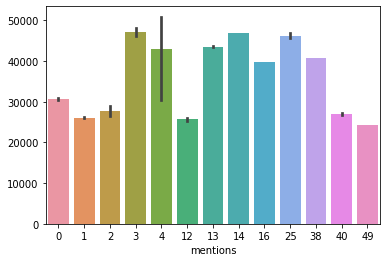

In [4]:
sns.barplot(x=cnnBrk.mentions,y=cnnBrk.index);
print(f"Mentions per news {round(cnnBrk.mentions.sum() / len(cnnBrk.index),4)}")

Hastags per news 0.0004


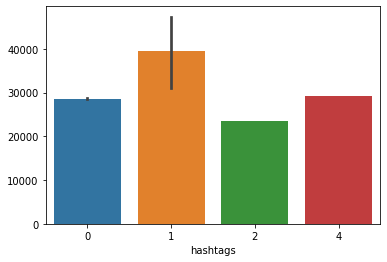

In [10]:
sns.barplot(x=cnnBrk.hashtags,y=cnnBrk.index);
print(f"Hastags per news {round(cnnBrk.hashtags.sum() / len(cnnBrk.index),4)}")

Media per news 0.5302


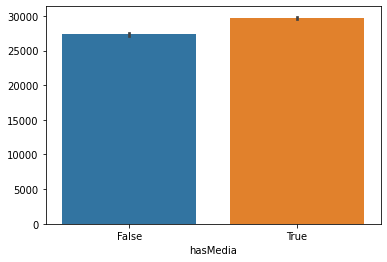

In [11]:
sns.barplot(x=cnnBrk.hasMedia,y=cnnBrk.index);
print(f"Media per news {round(len(cnnBrk[cnnBrk.hasMedia == True].index) / len(cnnBrk.index),4)}")

In [41]:
def generate_stat_block():
  cnnStat = get_statistics_for_dataset(cnnBrk, "CNN")
  bbcStat = get_statistics_for_dataset(bbc, "BBC")
  presstvStat = get_statistics_for_dataset(pressTV , "PressTV")
  reutersStat = get_statistics_for_dataset(reutersWorld, "Reuters")
  res = pd.DataFrame([cnnStat, presstvStat, reutersStat, bbcStat])
  return res
generate_stat_block()

,NI-count,avg_views,std_views,avg_hastags,avg_media,avg_mentions,agency
0,48471,88.985827,99.930244,0.0004,0.5302,0.4697,CNN
1,7860,1183.157888,337.592685,0.0004,0.9205,0.0219,PressTV
2,11307,221.345715,94.197241,0.0001,0.1633,0.9990,Reuters
3,1838,678.303047,1930.809073,0.1436,0.9233,0.3836,BBC


# Distribution Assumptions
We can now also test the distribution assumptions for the views variable made by the authors.
For this we check all 89 distributions available in Skicit-Learn: (https://docs.scipy.org/doc/scipy/reference/stats.html)

## Issues Found

* **Which 89 distributions did they acutally test?** Scipy includes more distributions than 89 and is continually updated, so just linking to the page above is not enough ...

* **Which metric was used to evaluate goodness of fit of the dist.?** No metric is repoted in the paper.

* **Distributions do NOT MATCH with the paper !!**

In [26]:
import scipy.stats as st
from scipy.stats._continuous_distns import _distn_names
import numpy as np
import warnings
import csv

def test_distribution(data, dist):
    print(f"Testing distribution {dist}")
    label = dist
    dist = getattr(st, dist)

    with warnings.catch_warnings():
      warnings.filterwarnings('ignore')
      try :
        params = dist.fit(data.views)

        #parameters of fitted distribution.
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        #calc pdf and error for fit.
        pdf = dist.pdf(np.arange(len(data.views)), loc=loc, scale=scale, *arg)
        sse = np.sum(np.power(data.views - pdf, 2.0))

        #calc Kolgorov-Smirnov
        dist, p = st.kstest(data.views, label, args=params)
      except ValueError:
        print(f"Could not process distribution {dist}")
        return False
    return {"name" : label, "params" : params, "Error" : sse, "P-Value" : p}

In [27]:
def test_best_distribution(data):
  results = []
  # Exclude levy_stable and studentized_range as their implementations in 
  # scipy suck and take a vast amount of time to compute.
  dist_to_test = [d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]
  for dist in dist_to_test:
    res = test_distribution(data, dist)
    if res:
      results.append(res)
  return sorted(results, key=lambda x:x["P-Value"])

def generate_and_save_distribution_tests_for(data, label):
  dists = test_best_distribution(data)
  cols = ["name", "params", "Error", "P-Value"]
  with open(f'distributions/{label}.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=cols)
    writer.writeheader()
    for d in dists:
      writer.writerow(d)
  print(f"Done processing distribution tests for {label}")

In [31]:
generate_and_save_distribution_tests_for(cnnBrk, "cnn_breaking")

Testing distribution ksone
Testing distribution kstwo
Could not process distribution <scipy.stats._continuous_distns.kstwo_gen object at 0x000001DA743735B0>
Testing distribution kstwobign
Testing distribution norm
Testing distribution alpha
Testing distribution anglit
Testing distribution arcsine
Testing distribution beta
Testing distribution betaprime
Testing distribution bradford
Testing distribution burr
Testing distribution burr12
Testing distribution fisk
Testing distribution cauchy
Testing distribution chi
Testing distribution chi2
Testing distribution cosine
Testing distribution dgamma
Testing distribution dweibull
Testing distribution expon
Testing distribution exponnorm
Testing distribution exponweib
Testing distribution exponpow
Testing distribution fatiguelife
Testing distribution foldcauchy
Testing distribution f
Testing distribution foldnorm
Testing distribution weibull_min
Testing distribution weibull_max
Testing distribution genlogistic
Testing distribution genpareto
Tes

In [30]:
generate_and_save_distribution_tests_for(reutersWorld, "reuters")

Testing distribution ksone
Testing distribution kstwo
Could not process distribution <scipy.stats._continuous_distns.kstwo_gen object at 0x000001DA743735B0>
Testing distribution kstwobign
Testing distribution norm
Testing distribution alpha
Testing distribution anglit
Testing distribution arcsine
Testing distribution beta
Testing distribution betaprime
Testing distribution bradford
Testing distribution burr
Testing distribution burr12
Testing distribution fisk
Testing distribution cauchy
Testing distribution chi
Testing distribution chi2
Testing distribution cosine
Testing distribution dgamma
Testing distribution dweibull
Testing distribution expon
Testing distribution exponnorm
Testing distribution exponweib
Testing distribution exponpow
Testing distribution fatiguelife
Testing distribution foldcauchy
Testing distribution f
Testing distribution foldnorm
Testing distribution weibull_min
Testing distribution weibull_max
Testing distribution genlogistic
Testing distribution genpareto
Tes

In [28]:
generate_and_save_distribution_tests_for(bbc, "bbc")

Testing distribution ksone
Testing distribution kstwo
Could not process distribution <scipy.stats._continuous_distns.kstwo_gen object at 0x000001DA743735B0>
Testing distribution kstwobign
Testing distribution norm
Testing distribution alpha
Testing distribution anglit
Testing distribution arcsine
Testing distribution beta
Testing distribution betaprime
Testing distribution bradford
Testing distribution burr
Testing distribution burr12
Testing distribution fisk
Testing distribution cauchy
Testing distribution chi
Testing distribution chi2
Testing distribution cosine
Testing distribution dgamma
Testing distribution dweibull
Testing distribution expon
Testing distribution exponnorm
Testing distribution exponweib
Testing distribution exponpow
Testing distribution fatiguelife
Testing distribution foldcauchy
Testing distribution f
Testing distribution foldnorm
Testing distribution weibull_min
Testing distribution weibull_max
Testing distribution genlogistic
Testing distribution genpareto
Tes

In [29]:
generate_and_save_distribution_tests_for(pressTV, "presstv")

Testing distribution ksone
Testing distribution kstwo
Could not process distribution <scipy.stats._continuous_distns.kstwo_gen object at 0x000001DA743735B0>
Testing distribution kstwobign
Testing distribution norm
Testing distribution alpha
Testing distribution anglit
Testing distribution arcsine
Testing distribution beta
Testing distribution betaprime
Testing distribution bradford
Testing distribution burr
Testing distribution burr12
Testing distribution fisk
Testing distribution cauchy
Testing distribution chi
Testing distribution chi2
Testing distribution cosine
Testing distribution dgamma
Testing distribution dweibull
Testing distribution expon
Testing distribution exponnorm
Testing distribution exponweib
Testing distribution exponpow
Testing distribution fatiguelife
Testing distribution foldcauchy
Testing distribution f
Testing distribution foldnorm
Testing distribution weibull_min
Testing distribution weibull_max
Testing distribution genlogistic
Testing distribution genpareto
Tes

# Label into top 5% and top 25%

## Issues Found

* **How are the labels applied?** My guess would be via a categorical variable as target, which is also what is applied below.

* **Are there separate datasets for 25% and 5%?** I would guess this should be the case, since they mention _"Therefore, we first found the thresholds that satisfy these percent-
ages for training and test sets and assigned a binary label to each
post (“popular” or “not popular”). "_ I would say this suggest they do the experiments two times, once for each popularity prediction percentge.

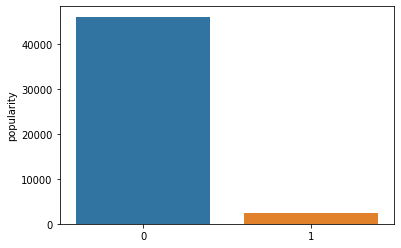

In [ ]:
def produce_binary_labels(df):
  sorted = df.sort_values(by='views', ascending=False)
  top5_indices = sorted.head(int(len(df)*(5/100))).index
  top25_indices = sorted.head(int(len(df)*(25/100))).index

  # Create the target, 0 for not popular, 1 for popular
  df.loc[:,'popularity'] = 0

  top5_set = df.copy()
  top25_set = df.copy()

  top5_set.loc[top5_indices,'popularity'] = 1
  top25_set.loc[top25_indices,'popularity'] = 1

  return top5_set, top25_set

cnnBrk5, cnnBrk25 = produce_binary_labels(cnnBrk)
sns.barplot(x=[0,1], y=cnnBrk5.groupby('popularity').popularity.count());

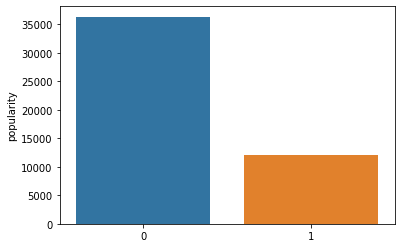

In [ ]:
sns.barplot(x=[0,1], y=cnnBrk25.groupby('popularity').popularity.count());

# Split into Training/Test

## Issues Found

* **Maybe there are imbalances in train/test due to holidays or 
interesting news topics in those months?** (Just a thought)

* **Very few training samples!** The authors use 86.65% of their data for training, leaving just shy of 14% for testing. That may be an issue in case of overfitting.

* **They don't mention which columns are scaled!!** This results in static cols,
such as the std of views etc. to get put to 0!!

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def create_train_test_split(df):
  # the first six months of the data is selected for training and the last month 
  # is selected for testing.
   # March 8, 2017 to October 8, 2017.
  train_start = "2017-03-08"
  train_end = "2017-9-08"
  mask = (df.date > train_start) & (df.date <= train_end)

  df = df.drop(labels=['date'],axis=1)
  df.mediaType = df.mediaType.astype('category').cat.codes

  training = df.loc[mask]
  test = df.loc[-mask]

  # Apply Min-Max scaling fitted on the training data
  scaler = MinMaxScaler()
  scaled_training = pd.DataFrame(scaler.fit_transform(training), columns=df.columns)
  scaled_test = pd.DataFrame(scaler.transform(test), columns=df.columns)

  return scaled_training, scaled_test

cnnTrain5, cnnTest5 = create_train_test_split(cnnBrk5)
print(f"Size of Training set: {len(cnnTrain5.index)}")
print(f"Size of Test set: {len(cnnTest5.index)}")
print(f"Percentage of train split: {round(100 * len(cnnTrain5.index) / len(cnnBrk.index),2)}%")

Size of Training set: 41998
Size of Test set: 6473
Percentage of train split: 86.65%


In [ ]:
cnnTrain25, cnnTest25 = create_train_test_split(cnnBrk25)
print(f"Size of Training set: {len(cnnTrain25.index)}")
print(f"Size of Test set: {len(cnnTest25.index)}")
print(f"Percentage of train split: {round(100 * len(cnnTrain25.index) / len(cnnBrk.index),2)}%")

Size of Training set: 41998
Size of Test set: 6473
Percentage of train split: 86.65%


# SVM Partial Models

We will follow the paper and find the tuning parameter **c** by applying **5-fold CV**. We will collect the same 5 metrics mentioned in the paper. 

We also also try feature selection using randomized Lasso, as mentioned in the paper. Should their assumptions hold, the results should be that no substantial improvement can be shown.

Before training we also have to also apply the sample weighting technique mentioned for the MTL: _"Both of these models
also use a sample weighting technique, exactly the same as the one
used for MTL."_

## Issues Found

* **SVM also has other hyperparameters that they don't mention!!** These include gamma and kernel (and degree for some kernels). As they don't mention these parameters, we will just assume the default is used.

* **Not mentioned wether they do GridSearch of Randomized Search for the hyperparameter tuning!**

* **Which range of parameters for c is the search based on?** They only mention that they use 5-fold CV, but not over which range of parameters. We will just have to take some arbitrary values and hope for the best.

* **Which metric is used to decide which CV fold is the best?** E.g. which
scorer should be used to determine the optimal 'C' hyperparamter.

* **Which Kernel do they use?** Since they use linear normalization, I guess one
would use a linear kernel? This would also make the computation much faster...

In [6]:
def calculate_weights(train_df):
  n = len(train_df.index)
  labels = train_df.popularity
  popular = len(labels[labels == 1])
  not_popular = n - popular

  denominator = sum((1 / (popular if labels[k] == 1 else not_popular)) for k in range(1,n))
  bigLambda = map(lambda i: (1 / (popular if labels[i] == 1 else not_popular)) * denominator, range(0, n))
  return pd.Series(bigLambda)

bigLambdaCnn25 = calculate_weights(cnnTrain25)
bigLambdaCnn25.value_counts()

NameError: name 'cnnTrain25' is not defined

In [7]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import pickle

def train_svm_wo_feature_select(train_df, weights):
  weight_array = weights.unique()
  weight_dict = {0 : weight_array[0], 1 : weight_array[1]}
  param_grid = {'C' : np.logspace(-3, 2, 6)}

  # Do 5-fold CV
  # Use LinearSVC as we get quadratic scaling for the standard RFB
  # kernel otherwise, which is unreasonable given the amount of data.
  gridSearch = GridSearchCV(LinearSVC(class_weight=weight_dict), param_grid,
                            verbose=1) 
  model = gridSearch.fit(train_df.drop('popularity', axis=1), 
                         train_df.popularity)
  print(f"Found best model :{model.best_params_}")
  return model

#modelCnn25 = train_svm_wo_feature_select(cnnTrain25, bigLambdaCnn25)
#with open('modelCnn25.pkl', 'wb') as fid:
#    pickle.dump(modelCnn25, fid)

In [8]:
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def calculate_metrics_for_model(model, test_df):
  # Get predictions from model
  test_preds = model.predict(test_df.drop('popularity', axis=1))
  test_accuracy = accuracy_score(test_df.popularity, test_preds)
  test_balanced_acc = balanced_accuracy_score(test_df.popularity, test_preds)
  test_f1 = f1_score(test_df.popularity, test_preds)
  test_precision = precision_score(test_df.popularity, test_preds)
  test_recall = recall_score(test_df.popularity, test_preds)

  print("Confusion Matrix".center(50,"-"))
  ConfusionMatrixDisplay.from_estimator(model, test_df.drop('popularity', axis=1), test_df.popularity)
  plt.show()
  
  return {"Accuracy" : test_accuracy, "Balanced_Accuracy": test_balanced_acc, 
          "Precision": test_precision, "Recall": test_recall, "F1": test_f1}

#cnn25Metrics = calculate_metrics_for_model(modelCnn25, cnnTest25)
#print(cnn25Metrics)

# Evaluation of model + generation for other datasets

In [9]:
def get_results_for_dataset(df, name):
  print(name.center(50,"="))

  # Create labbeled train test splits for 5% and 25%
  train, test = create_train_test_split(df)
  train5, train25 = produce_binary_labels(train)
  test5, test25 = produce_binary_labels(test)

  # Train models for 5% and 25%
  results_5 = get_model_results(train5, test5)
  results_25 = get_model_results(train25, test25)

  # Save best models to disk
  with open(f'{name}_5.pkl', 'wb') as fid:
    pickle.dump(results_5['model'], fid)  

  with open(f'{name}_25.pkl', 'wb') as fid:
    pickle.dump(results_25['model'], fid)  
  
  print(f"Results for dataset {name}:")
  print(f"5% Popularity: {results_5['metrics']}")
  print(f"25% Popularity: {results_25['metrics']}")
  return {"5" : results_5, "25" : results_25}

def get_model_results(train, test):
  train_weights = calculate_weights(train)
  model = train_svm_wo_feature_select(train, train_weights)
  metrics = calculate_metrics_for_model(model, test)
  return {"model" : model, "metrics" : metrics}

## Reuters World

=====================Reuters======================
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model :{'C': 100.0}
-----------------Confusion Matrix-----------------


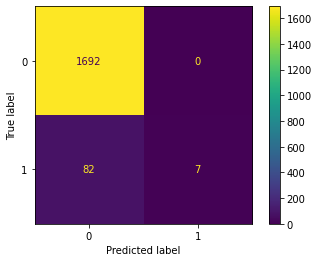

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model :{'C': 10.0}
-----------------Confusion Matrix-----------------


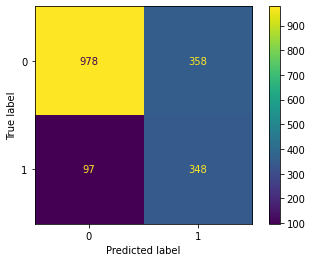

Results for dataset Reuters:
5% Popularity: {'Accuracy': 0.9539584503088153, 'Balanced_Accuracy': 0.5393258426966292, 'Precision': 1.0, 'Recall': 0.07865168539325842, 'F1': 0.14583333333333334}
25% Popularity: {'Accuracy': 0.7445255474452555, 'Balanced_Accuracy': 0.7570292000269124, 'Precision': 0.49291784702549574, 'Recall': 0.7820224719101123, 'F1': 0.6046915725456125}


In [ ]:
resReuters = get_results_for_dataset(reutersWorld, "Reuters")

## CNN

=======================CNN========================
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model :{'C': 100.0}
-----------------Confusion Matrix-----------------


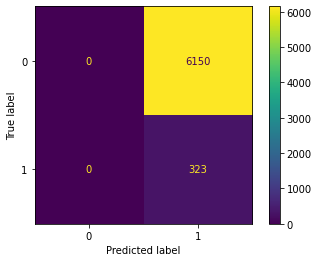

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model :{'C': 100.0}
-----------------Confusion Matrix-----------------


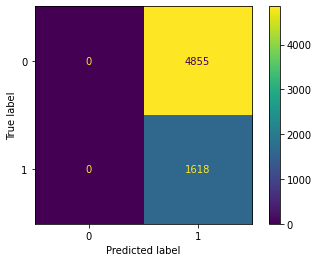

Results for dataset CNN:
5% Popularity: {'Accuracy': 0.0498995828827437, 'Balanced_Accuracy': 0.5, 'Precision': 0.0498995828827437, 'Recall': 1.0, 'F1': 0.09505591524426132}
25% Popularity: {'Accuracy': 0.2499613780318245, 'Balanced_Accuracy': 0.5, 'Precision': 0.2499613780318245, 'Recall': 1.0, 'F1': 0.399950562353232}


In [ ]:
resCNN = get_results_for_dataset(cnnBrk, "CNN")

## Press TV

=====================PressTV======================
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model :{'C': 100.0}
-----------------Confusion Matrix-----------------


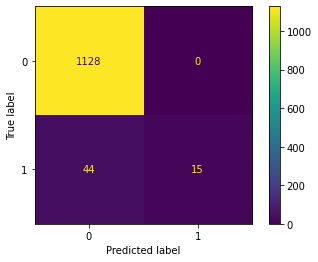

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model :{'C': 100.0}
-----------------Confusion Matrix-----------------


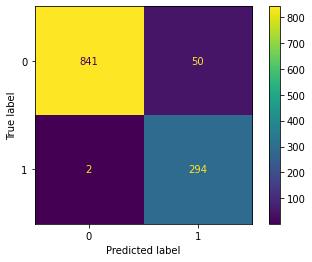

Results for dataset PressTV:
5% Popularity: {'Accuracy': 0.9629317607413648, 'Balanced_Accuracy': 0.6271186440677966, 'Precision': 1.0, 'Recall': 0.2542372881355932, 'F1': 0.4054054054054054}
25% Popularity: {'Accuracy': 0.9561920808761584, 'Balanced_Accuracy': 0.9685632602299269, 'Precision': 0.8546511627906976, 'Recall': 0.9932432432432432, 'F1': 0.91875}


In [ ]:
resPressTV = get_results_for_dataset(pressTV, "PressTV")

## BBC

In [10]:
resBBC = get_results_for_dataset(bbc, "BBC")

=======================BBC========================


NameError: name 'create_train_test_split' is not defined

## Results

The results seem similar for some of the models, but not very good for most metrics. This is probably due to inconsistencies mentioned above caused by
the authors leaving out critical information about the algorithm's hyperparamters and the pre-processing of the dataset.

From my guesses I would also say that we don't have a model that fits the
data good enough. Maybe it isn't linearily seperable. Henceforth, a simple
LinearSVC does not suffice. 

Another probable issue is the massive imbalance between training and test samples. Test sets are small to begin with, and by labelling the data using
only 5% and 25% of the data, we reduce the quantity of popular news to 
next to nothing. For this reason, most classifiers on 5% seem to just overfit
the Unpopular News (label 0) class.
